In [1]:
from mpasanalysis import *
import e3sm_res_cmp
%matplotlib inline

In [2]:
# get paths of restart files, monthly mean output files, processed climatology files and output figures
data_root = e3sm_res_cmp.load_paths_ocn(climo_ys=41, climo_ye=50, ts_ys=1, ts_ye=50)
rst_root = data_root['rst_root']
climo_root = data_root['climo_root']
mon_root = data_root['mon_root']
fig_root = data_root['fig_root']
rst_file = rst_root+'/mpaso.rst.0051-01-01_00000.nc'

Running on machine pn1803144.lanl.gov


In [3]:
# flags

In [4]:
# load dataset
f_rst = Dataset(rst_file, 'r')

In [5]:
# read grid information
lon = np.degrees(f_rst.variables['lonCell'][:])
lat = np.degrees(f_rst.variables['latCell'][:])
cellArea = f_rst.variables['areaCell'][:]

refBottomDepth = f_rst.variables['refBottomDepth'][:]
nVertLevels = len(refBottomDepth)
refTopDepth = np.zeros(nVertLevels)
refTopDepth[1:nVertLevels] = refBottomDepth[0:nVertLevels-1]
refLayerThickness = refTopDepth-refBottomDepth
refMidDepth = 0.5*(refTopDepth+refBottomDepth)

## Vertical transect

In [6]:
# cross section 1
s1_s_lat = 63
s1_s_lon = 296
s1_e_lat = 50
s1_e_lon = 320
# cross section 2 (WOCE AR7W)
s2_s_lat = 53.5
s2_s_lon = 304.5
s2_e_lat = 61
s2_e_lon = 312
# cross section 3
s3_s_lat = 66
s3_s_lon = 298
s3_e_lat = 67
s3_e_lon = 306
# list of depths
depth_list = [0, 100, 200, 500, 1000]

In [7]:
def gc_angles(lon, lat):
    lat0 = np.zeros(lat.size)
    lon0 = np.zeros(lon.size)
    lat1 = np.zeros(lat.size)
    lon1 = np.zeros(lon.size)
    lat0[1:-1] = lat[0:-2]
    lat1[1:-1] = lat[2:]
    lon0[1:-1] = lon[0:-2]
    lon1[1:-1] = lon[2:]
    angles = gc_angle(lon0, lat0, lon1, lat1)
    angles[0] = angles[1]
    angles[-1] = angles[-2]
    return angles

In [8]:
def test_vcsec_vector(mpaso_data_x, mpaso_data_y, lon0, lat0, lon1, lat1, depth=5500):
    
    levels = np.linspace(-0.3, 0.3, 21)
    # maps 
    fig, axarr = plt.subplots(1,2)
    fig.set_size_inches(12, 6)
    mpaso_map_x = mpaso_data_x.get_map()
    mpaso_map_y = mpaso_data_y.get_map()
    m0,tmp = mpaso_map_x.plot(region='LabSea', axis=axarr[0], levels=levels, cmap='RdBu_r')
    m1,tmp = mpaso_map_y.plot(region='LabSea', axis=axarr[1], levels=levels, cmap='RdBu_r')
    m0.drawgreatcircle(lon0, lat0, lon1, lat1, color='y', linewidth=2)
    m1.drawgreatcircle(lon0, lat0, lon1, lat1, color='y', linewidth=2)
    
    # cross section of zonal and meridional component 
    fig, axarr = plt.subplots(1,2)
    fig.set_size_inches(12, 4)
    mpaso_vcsec_x = mpaso_data_x.get_vertical_cross_section(lon0=lon0, lat0=lat0,
                                                             lon1=lon1, lat1=lat1, depth_bottom=depth)
    mpaso_vcsec_y = mpaso_data_y.get_vertical_cross_section(lon0=lon0, lat0=lat0,
                                                             lon1=lon1, lat1=lat1, depth_bottom=depth)
    mpaso_vcsec_x.plot(ptype='pcolor', depth_mode='native', axis=axarr[0], levels=levels, cmap='RdBu_r')
    mpaso_vcsec_y.plot(ptype='pcolor', depth_mode='native', axis=axarr[1], levels=levels, cmap='RdBu_r')

    # show locations of data point along cross section
    lon_cs = mpaso_vcsec_x.lon
    lat_cs = mpaso_vcsec_x.lat
    x, y = m(lon_cs, lat_cs)
    m0.scatter(x, y, s=2, c='r', zorder=3)
    m1.scatter(x, y, s=2, c='r', zorder=3)
    
    # cross section of normal component
    fig = plt.figure(figsize=[6,4])
    angles_cs = gc_angles(lon_cs, lat_cs)
    depth_cs = mpaso_vcsec_x.depth
    nd = depth_cs.size
    data_cs = np.zeros(mpaso_vcsec_x.data.shape)
    for i in np.arange(nd):
        data_cs[:,i] = -mpaso_vcsec_x.data[:,i]*np.sin(angles_cs)+mpaso_vcsec_y.data[:,i]*np.cos(angles_cs)
    mpaso_vcsec = MPASOVertCrossSection(data=data_cs, lon=lon_cs, lat=lat_cs, dist=mpaso_vcsec_x.dist,
                                         depth=mpaso_vcsec_x.depth, name='Normal Velocity', units='m/s')
    mpaso_vcsec.plot(ptype='pcolor', depth_mode='native', levels=levels, cmap='RdBu_r')

In [9]:
def test_transect_vector(mpaso_data_x, mpaso_data_y, transect):
    lon0 = transect.lon0
    lat0 = transect.lat0
    lon1 = transect.lon1
    lat1 = transect.lat1
    
    levels = np.linspace(-0.3, 0.3, 21)
    # cross section of zonal and meridional component 
    mpaso_vcsec_x = mpaso_data_x.get_transect(transect)
    mpaso_vcsec_y = mpaso_data_y.get_transect(transect)

    # show locations of data point along cross section
    lon_cs = mpaso_vcsec_x.lon
    lat_cs = mpaso_vcsec_x.lat
    
    # cross section of normal component
    fig = plt.figure(figsize=[6,4])
    angles_cs = gc_angles(lon_cs, lat_cs)
    depth_cs = mpaso_vcsec_x.depth
    nd = depth_cs.size
    data_cs = np.zeros(mpaso_vcsec_x.data.shape)
    for i in np.arange(nd):
        data_cs[:,i] = -mpaso_vcsec_x.data[:,i]*np.sin(angles_cs)+mpaso_vcsec_y.data[:,i]*np.cos(angles_cs)
    mpaso_vcsec = MPASOVertCrossSection(data=data_cs, lon=lon_cs, lat=lat_cs, dist=mpaso_vcsec_x.dist,
                                         depth=mpaso_vcsec_x.depth, name='Normal Velocity', units='m/s')
    mpaso_vcsec.plot(ptype='contourf', depth_mode='native', levels=levels, cmap='RdBu_r')

## Bathymetry

Plotting map of Bottom Depth (m) at region 'LabSea'


/Users/qingli/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'tri'
  s)


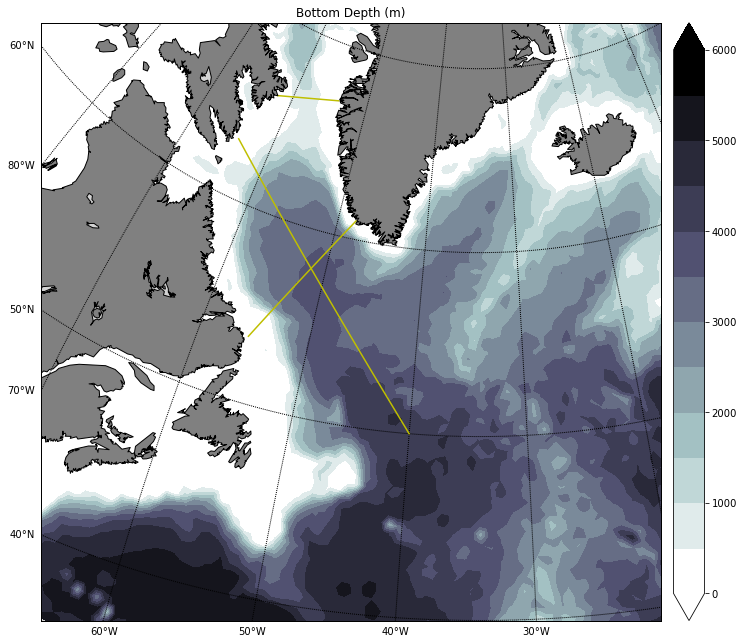

In [10]:
fig = plt.figure(figsize=[12,11])
levels = np.linspace(0, 6000, 13)
bottomDepth = f_rst.variables['bottomDepth'][:]
mpaso_bath = MPASOMap(data=bottomDepth, lat=lat, lon=lon, cellarea=cellArea, name='Bottom Depth', units='m')
m, f = mpaso_bath.plot(region='LabSea', ptype='contourf', cmap='bone_r', levels=levels)
# plot cross sections
m.drawgreatcircle(s1_s_lon, s1_s_lat, s1_e_lon, s1_e_lat, color='y')
m.drawgreatcircle(s2_s_lon, s2_s_lat, s2_e_lon, s2_e_lat, color='y')
m.drawgreatcircle(s3_s_lon, s3_s_lat, s3_e_lon, s3_e_lat, color='y')

plt.show()
# figname = fig_root+'/LabSea_bathymetry.png'
# fig.savefig(figname, dpi = 300)
# plt.close(fig)

Plotting map of velocityZonal at   5.00 m (m s^{-1}) at region 'LabSea'
Minimum and maximum markersizes: 30.47 and 90.51
Plotting map of velocityMeridional at   5.00 m (m s^{-1}) at region 'LabSea'
Minimum and maximum markersizes: 30.47 and 90.51
Nearest neighbor interpolation to 25 points.
Nearest neighbor interpolation to 25 points.


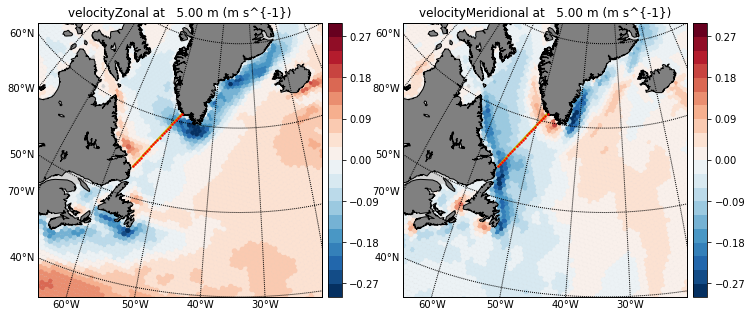

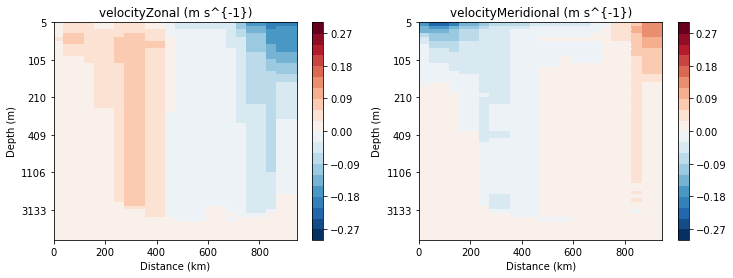

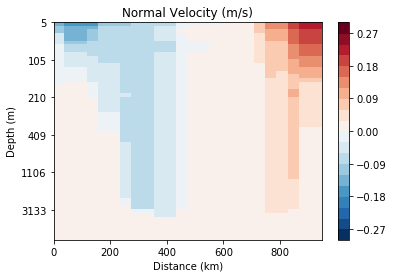

In [11]:
mon_file = mon_root+'/mpaso.hist.am.timeSeriesStatsMonthly.0041-01-01.nc'
f_mon = Dataset(mon_file, 'r')
ncvar_data_x = f_mon.variables['timeMonthly_avg_velocityZonal']
ncvar_data_y = f_mon.variables['timeMonthly_avg_velocityMeridional']
data_x = ncvar_data_x[0,:,:]
data_y = ncvar_data_y[0,:,:]

levels = np.linspace(-0.3, 0.3, 21)

mpaso_data_x = MPASOVolume(data=data_x, lon=lon, lat=lat, depth=refMidDepth, cellarea=cellArea,
                           layerthickness=refLayerThickness, name='velocityZonal',
                           units=ncvar_data_x.units)
mpaso_data_y = MPASOVolume(data=data_y, lon=lon, lat=lat, depth=refMidDepth, cellarea=cellArea,
                           layerthickness=refLayerThickness, name='velocityMeridional',
                           units=ncvar_data_x.units)

test_vcsec_vector(mpaso_data_x, mpaso_data_y, s2_s_lon, s2_s_lat, s2_e_lon, s2_e_lat )


Plotting map of velocityZonal at   5.00 m (m s^{-1}) at region 'LabSea'
Minimum and maximum markersizes: 30.47 and 90.51
Plotting map of velocityMeridional at   5.00 m (m s^{-1}) at region 'LabSea'
Minimum and maximum markersizes: 30.47 and 90.51
Nearest neighbor interpolation to 25 points.
Nearest neighbor interpolation to 25 points.


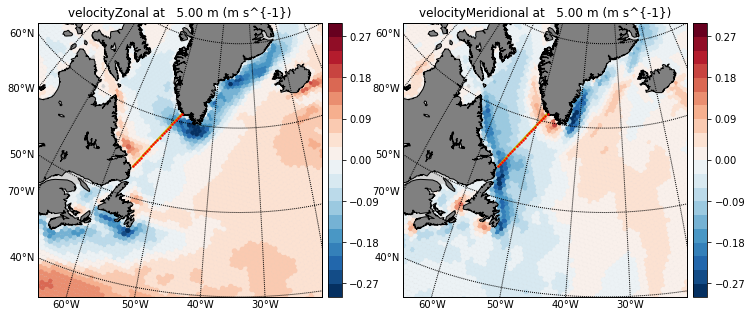

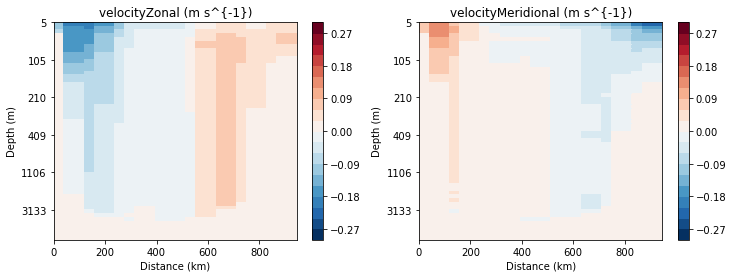

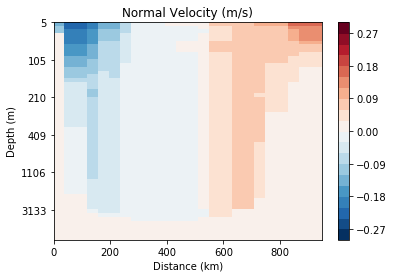

In [12]:

test_vcsec_vector(mpaso_data_x, mpaso_data_y, s2_e_lon, s2_e_lat, s2_s_lon, s2_s_lat )

Plotting map of velocityZonal at   5.00 m (m s^{-1}) at region 'LabSea'
Minimum and maximum markersizes: 30.47 and 90.51
Plotting map of velocityMeridional at   5.00 m (m s^{-1}) at region 'LabSea'
Minimum and maximum markersizes: 30.47 and 90.51
Nearest neighbor interpolation to 53 points.
Nearest neighbor interpolation to 53 points.


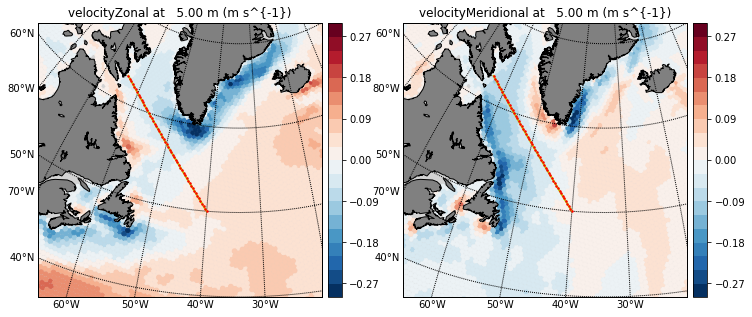

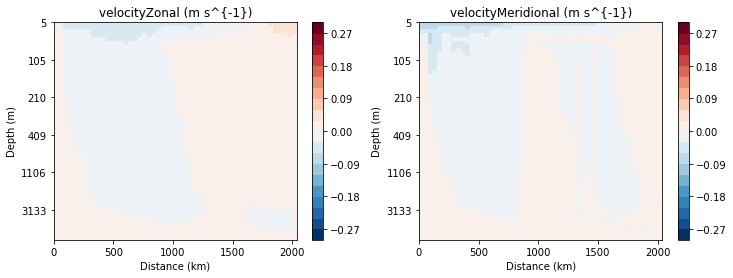

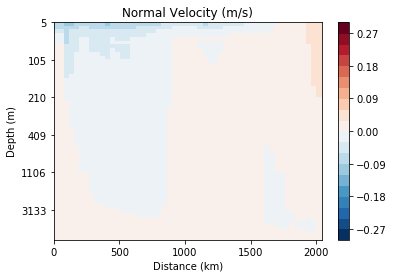

In [13]:

test_vcsec_vector(mpaso_data_x, mpaso_data_y, s1_s_lon, s1_s_lat, s1_e_lon, s1_e_lat )

Plotting map of velocityZonal at   5.00 m (m s^{-1}) at region 'LabSea'
Minimum and maximum markersizes: 30.47 and 90.51
Plotting map of velocityMeridional at   5.00 m (m s^{-1}) at region 'LabSea'
Minimum and maximum markersizes: 30.47 and 90.51
Nearest neighbor interpolation to 10 points.
Nearest neighbor interpolation to 10 points.


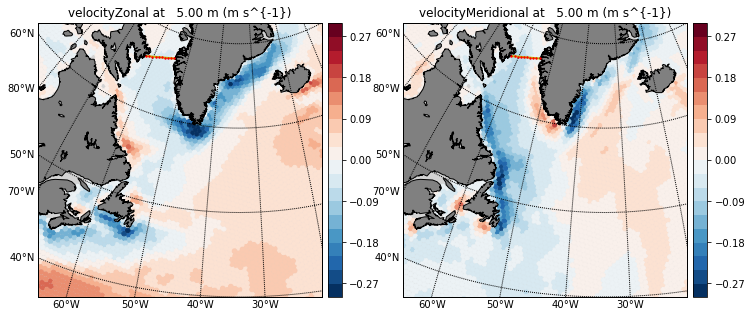

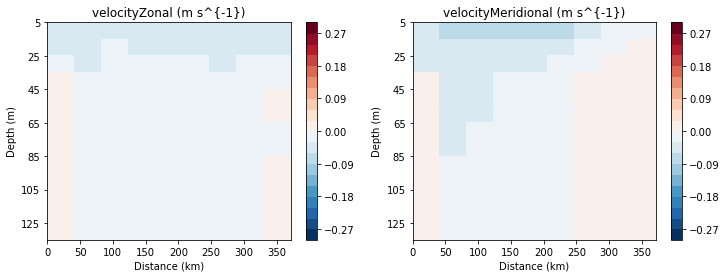

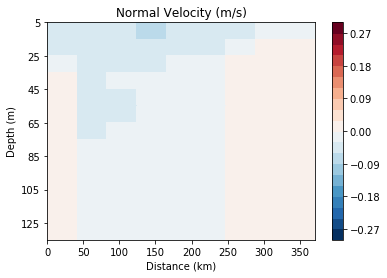

In [14]:

test_vcsec_vector(mpaso_data_x, mpaso_data_y, s3_s_lon, s3_s_lat, s3_e_lon, s3_e_lat, depth=150)

Plotting map of velocityZonal at   5.00 m (m s^{-1}) at region 'LabSea'
Minimum and maximum markersizes: 30.47 and 90.51
Plotting map of velocityMeridional at   5.00 m (m s^{-1}) at region 'LabSea'
Minimum and maximum markersizes: 30.47 and 90.51
Nearest neighbor interpolation to 22 points.
Nearest neighbor interpolation to 22 points.


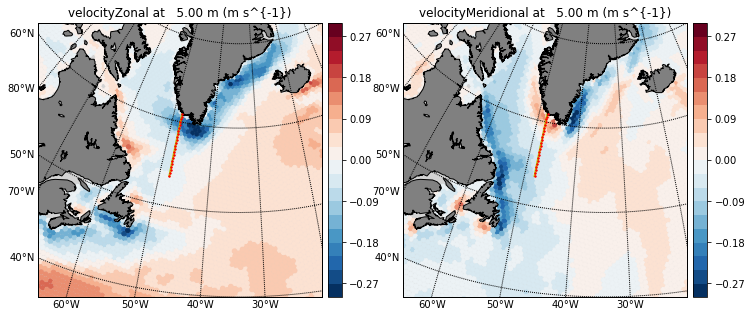

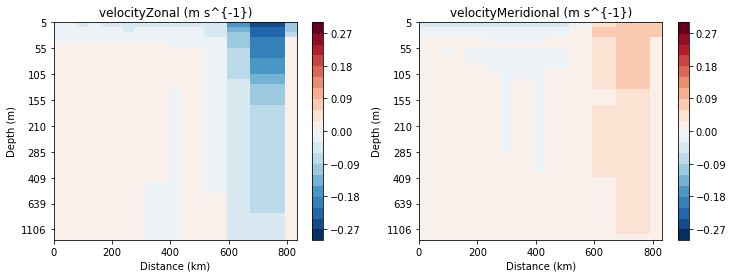

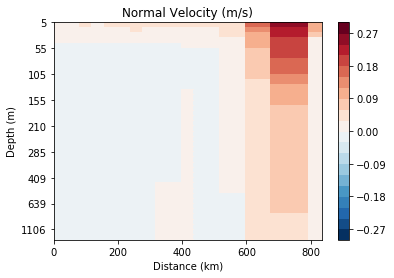

In [15]:
# cross section 2 (WOCE AR7W)
s4_s_lat = 53.5
s4_s_lon = 312
s4_e_lat = 61
s4_e_lon = 312
test_vcsec_vector(mpaso_data_x, mpaso_data_y, s4_s_lon, s4_s_lat, s4_e_lon, s4_e_lat, depth=1500)

Nearest neighbor interpolation to 25 points.
Nearest neighbor interpolation to 25 points.


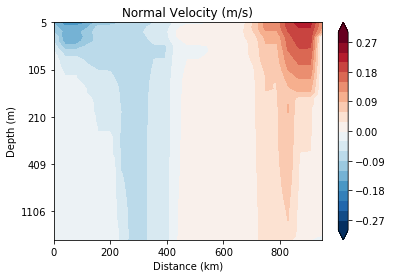

In [16]:
transect = VerticalTransect(lon0 = 304.5, lat0 = 53.5, lon1=312, lat1=61, depth=2500)
test_transect_vector(mpaso_data_x, mpaso_data_y, transect)

Nearest neighbor interpolation to 25 points.
Nearest neighbor interpolation to 25 points.


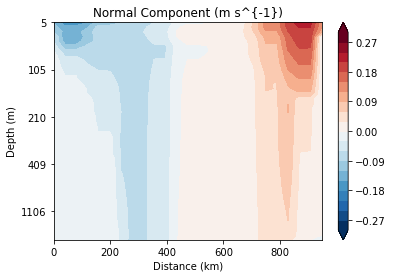

In [17]:
levels = np.linspace(-0.3, 0.3, 21)
transect = VerticalTransect(lon0 = 304.5, lat0 = 53.5, lon1=312, lat1=61, depth=2500)
plot_transect_vector(mpaso_data_x, mpaso_data_y, transect, levels=levels,
                     depth_mode='native', cmap='RdBu_r' )